In [28]:
import pandas as pd
import numpy as np
import spacy
import nltk
import string
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch

## Loading data

In [29]:
df = pd.read_csv('england_recent.csv')

## sample 10% of data, preprocess (lematization, no stopwords removal!)

In [30]:
from tqdm.notebook import tqdm
tqdm.pandas()


# Load SpaCy English model
nlp = spacy.load("en_core_web_sm")

# Sample 20% of the data 
df_sample = df.sample(frac=0.1, random_state=21).copy()
#df_sample = df.copy()

#only lematizing, want to keep as many words as possible. 
def preprocess_text(text):
    if pd.isnull(text):
        return ""
    doc = nlp(text.lower())
    return " ".join(token.lemma_ for token in doc if not token.is_punct and not token.is_space)


# Apply preprocessing with progress bar
for col in ['pros', 'cons', 'headline']:
    print(f"Processing column: {col}")
    df_sample[f'{col}_clean'] = df_sample[col].progress_apply(preprocess_text)

# Preview result
df_sample[['pros_clean', 'cons_clean', 'headline_clean']].head()

Processing column: pros


  0%|          | 0/12762 [00:00<?, ?it/s]

Processing column: cons


  0%|          | 0/12762 [00:00<?, ?it/s]

Processing column: headline


  0%|          | 0/12762 [00:00<?, ?it/s]

,pros_clean,cons_clean,headline_clean
73417,good environment free food flexible hour,night shift compulsory low pay,member
59426,invest heavily in you to get you promote,abandon you when contract be lose,great company when you be not a threat to othe...
10562,good company to work for,no downside to work here,review
50951,excellent salary colleague can be quite friend...,almost sexist mindset difficult to learn train...,unless you be prepared for absolutely anything...
88667,alright for a first job some supervisor be ver...,very low pay force to stand in one place for 8...,retail assistant


In [31]:
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

## Getting rid of the ultra long reviews as they are hard to tokenize

In [32]:
def is_too_long(text, max_tokens=300):
    try:
        prompt = f"Sentiment toward 'placeholder': {text.strip()}"
        tokens = tokenizer(prompt, return_tensors="pt", truncation=False)
        return tokens["input_ids"].shape[1] > max_tokens
    except:
        return True  # Skip anything that breaks

df_sample['too_long_pro'] = df_sample['pros'].apply(lambda x: is_too_long(x, max_tokens=300))
df_sample['too_long_con'] = df_sample['cons'].apply(lambda x: is_too_long(x, max_tokens=300))

# Filter them out
df_sample = df_sample[~(df_sample['too_long_pro'] | df_sample['too_long_con'])]


Token indices sequence length is longer than the specified maximum sequence length for this model (579 > 512). Running this sequence through the model will result in indexing errors


## Moving to ASBA analysis

In [33]:
def get_aspect_sentiment(text, aspect, tone):
    if pd.isnull(text):
        return None

    # Compose prompt-like input for aspect analysis
    if tone == 'pos':
        combined = f"The following is a positive experience about {aspect}: {text}"
    else:
        combined = f"The following is a negative experience about {aspect}: {text}"

    inputs = tokenizer(combined, return_tensors="pt", truncation=True, max_length=512)

    with torch.no_grad():
        logits = model(**inputs).logits
    scores = softmax(logits.numpy()[0])

    # This model returns scores for: [1 star, 2 stars, 3 stars, 4 stars, 5 stars]
    star_labels = [1, 2, 3, 4, 5]
    result = dict(zip(star_labels, scores))
    result["label"] = star_labels[scores.argmax()]
    return result


In [34]:
df_sample = df_sample[
    (df_sample['pros_clean'].str.strip() != '') & (df_sample['cons_clean'].str.strip() != '')
]
print("Empty pros_clean:", (df_sample['pros_clean'].str.strip() == '').sum())
print("Empty cons_clean:", (df_sample['cons_clean'].str.strip() == '').sum())


Empty pros_clean: 0
Empty cons_clean: 0


In [35]:
from collections import Counter
failed_sentiment = Counter()

def analyze_all_aspect_groups(text, aspect_groups, tone):
    results = {}
    for aspect, keywords in aspect_groups.items():
        if any(kw in text.lower() for kw in keywords):
            sent = get_aspect_sentiment(text, aspect, tone)
            if sent:
                results[aspect] = sent
            else:
                failed_sentiment[aspect] += 1  # Track failures
    return results


In [36]:
aspect_groups = {
    "pay": ["pay", "salary", "compensation", "wage", "income", "bonus"],
    "management": ["management", "managers", "leadership", "boss", "supervisor"],
    "work-life balance": ["work-life balance", "balance", "working hours", "hours", "flexibility", "overtime", "holiday"],
    "growth": ["growth", "grow", "career", "promotion", "advancement", "development", "opportunity", "progress"],
    "stress & pressure": ["stress", "pressure", "burnout", "demanding", "high pressure", "overload", "long hours", "stressful"],
    "culture": ["culture", "environment", "atmosphere", "company culture", "values"],
    "diversity & inclusion": ["diversity", "inclusion", "equality", "equity", "inclusive", "minority", "belonging"],
    "travel": ["travel", "commute", "commuting", "relocation", "mobility"],
    "benefits": ["benefits", "perks", "healthcare", "insurance", "pension", "rewards", "gym", "lunch", "dental"],
    "remote work": ["remote", "work from home", "wfh", "home office", "hybrid", "telework"],
    "flexibility": ["flexible", "flexibility", "adjustable schedule", "shift", "adaptable"],
    "people": ["people", "colleagues", "collegues", "coworker", "coworkers", "community", "teammates"],
    "training & onboarding": ["training", "onboarding", "orientation", "new hire", "introduction", "induction"],
    "job role clarity": ["role", "responsibility", "job description", "tasks", "duties", "expectation", "scope"],
    "tools & resources": ["tools", "resources", "equipment", "software", "support", "access", "tech stack", "technology"],
    "performance feedback": ["feedback", "review", "appraisal", "evaluation", "performance", "supervision", "goals"],
    "job security": ["job security", "layoff", "firing", "termination", "redundancy", "stable job"],
    "teamwork & collaboration": ["team", "teamwork", "collaboration", "supportive", "helpful", "team spirit", "group"]
}
def safe_analyze(text, aspect_groups, tone):
    try:
        return analyze_all_aspect_groups(text, aspect_groups, tone)
    except Exception as e:
        print(f"Failed on: {repr(text)}\nError: {e}")
        return {}

# Modified ABSA to use grouped aspect synonyms

df_sample['Clean_pro_aspect_sentiments'] = df_sample['pros_clean'].progress_apply(lambda x: analyze_all_aspect_groups(x, aspect_groups, tone='pos'))
df_sample['Clean_con_aspect_sentiments'] = df_sample['cons_clean'].progress_apply(lambda x: analyze_all_aspect_groups(x, aspect_groups, tone='neg'))

df_sample['pro_aspect_sentiments'] = df_sample['pros'].progress_apply(lambda x: analyze_all_aspect_groups(x, aspect_groups, tone='pos'))
df_sample['con_aspect_sentiments'] = df_sample['cons'].progress_apply(lambda x: analyze_all_aspect_groups(x, aspect_groups, tone='neg'))

  0%|          | 0/12636 [00:00<?, ?it/s]

  0%|          | 0/12636 [00:00<?, ?it/s]

  0%|          | 0/12636 [00:00<?, ?it/s]

  0%|          | 0/12636 [00:00<?, ?it/s]

Applying aspect group to uncleaned pros/cons worked better since it maintains more context

leaving both in df but should go with the non clean ones

In [37]:
# Full list of all aspect labels from your aspect_groups
all_aspects = list(aspect_groups.keys())
pro_counts= Counter()
con_counts = Counter()
pro_counts_clean = Counter()
con_counts_clean = Counter()

for row in df_sample['pro_aspect_sentiments'].dropna():
    pro_counts.update(row.keys())
for row in df_sample['con_aspect_sentiments'].dropna():
    con_counts.update(row.keys())

for row in df_sample['Clean_pro_aspect_sentiments'].dropna():
    pro_counts_clean.update(row.keys())
for row in df_sample['Clean_con_aspect_sentiments'].dropna():
    con_counts_clean.update(row.keys())


# Ensure all aspects appear, even if 0
pro_data = [(aspect, pro_counts.get(aspect, 0)) for aspect in all_aspects]
con_data = [(aspect, con_counts.get(aspect, 0)) for aspect in all_aspects]

# Sort by count
pro_data.sort(key=lambda x: x[1])
con_data.sort(key=lambda x: x[1])

# Ensure all aspects appear, even if 0
pro_data_clean = [(aspect, pro_counts_clean.get(aspect, 0)) for aspect in all_aspects]
con_data_clean = [(aspect, con_counts_clean.get(aspect, 0)) for aspect in all_aspects]

# Sort by count
pro_data_clean.sort(key=lambda x: x[1])
con_data_clean.sort(key=lambda x: x[1])

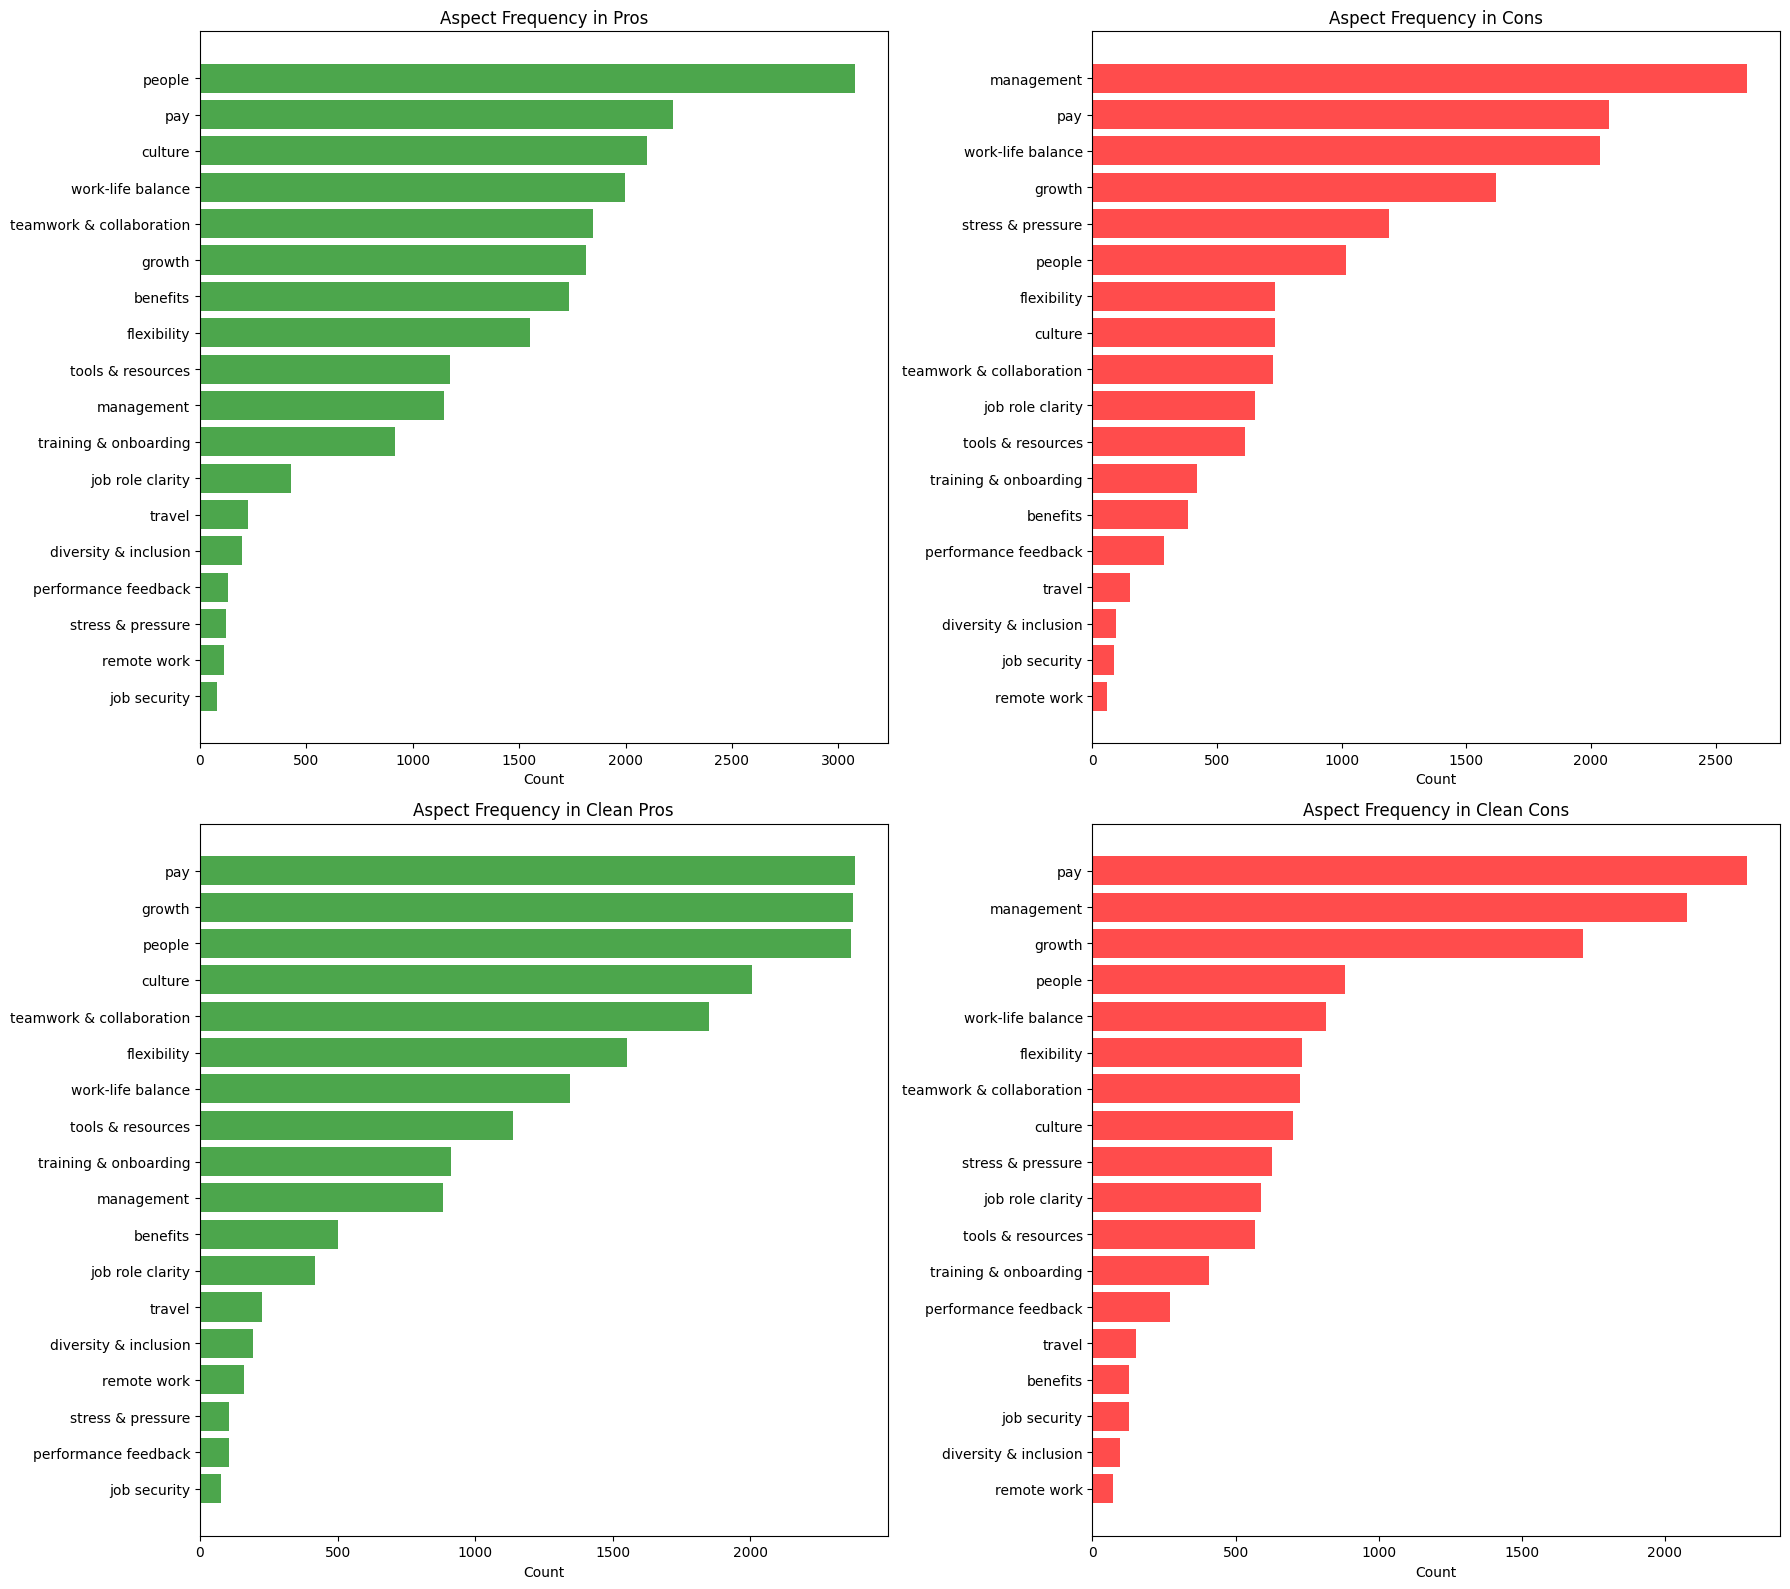

In [38]:
import matplotlib.pyplot as plt

# Prepare data (already done earlier)
# pro_data, con_data, pro_data_clean, con_data_clean assumed to be available

# Create 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(18, 16))  # Wider and taller figure for readability

# Plot 1: Pros
axs[0, 0].barh([a for a, c in pro_data], [c for a, c in pro_data], color='green', alpha=0.7)
axs[0, 0].set_title("Aspect Frequency in Pros")
axs[0, 0].set_xlabel("Count")

# Plot 2: Cons
axs[0, 1].barh([a for a, c in con_data], [c for a, c in con_data], color='red', alpha=0.7)
axs[0, 1].set_title("Aspect Frequency in Cons")
axs[0, 1].set_xlabel("Count")

# Plot 3: Clean Pros
axs[1, 0].barh([a for a, c in pro_data_clean], [c for a, c in pro_data_clean], color='green', alpha=0.7)
axs[1, 0].set_title("Aspect Frequency in Clean Pros")
axs[1, 0].set_xlabel("Count")

# Plot 4: Clean Cons
axs[1, 1].barh([a for a, c in con_data_clean], [c for a, c in con_data_clean], color='red', alpha=0.7)
axs[1, 1].set_title("Aspect Frequency in Clean Cons")
axs[1, 1].set_xlabel("Count")

# Adjust layout
plt.tight_layout()
plt.show()


In [39]:
df_sample.to_csv('aspect_checsk.csv')

In [45]:
print("Uncleaned counts:")
print(f"{'Aspect':<25}{'Pros Count':>12}{'Cons Count':>12}")
print("-" * 50)

for aspect in all_aspects:
    pros = pro_counts.get(aspect, 0)
    cons = con_counts.get(aspect, 0)
    print(f"{aspect:<25}{pros:>12}{cons:>12}")


Uncleaned counts:
Aspect                     Pros Count  Cons Count
--------------------------------------------------
pay                              2223        2073
management                       1147        2627
work-life balance                1998        2038
growth                           1815        1618
stress & pressure                 121        1189
culture                          2099         732
diversity & inclusion             199          96
travel                            225         152
benefits                         1733         383
remote work                       115          58
flexibility                      1553         733
people                           3077        1016
training & onboarding             918         418
job role clarity                  427         651
tools & resources                1176         610
performance feedback              130         287
job security                       78          87
teamwork & collaboration       

In [47]:
print("Cleaned counts:")
print(f"{'Aspect':<25}{'Pros Count':>12}{'Cons Count':>12}")
print("-" * 50)

for aspect in all_aspects:
    pros = pro_counts_clean.get(aspect, 0)
    cons = con_counts_clean.get(aspect, 0)
    print(f"{aspect:<25}{pros:>12}{cons:>12}")


Cleaned counts:
Aspect                     Pros Count  Cons Count
--------------------------------------------------
pay                              2379        2288
management                        884        2077
work-life balance                1344         816
growth                           2374        1715
stress & pressure                 107         629
culture                          2006         702
diversity & inclusion             194          96
travel                            225         152
benefits                          500         127
remote work                       161          73
flexibility                      1553         733
people                           2366         882
training & onboarding             912         407
job role clarity                  417         588
tools & resources                1138         568
performance feedback              104         271
job security                       78         126
teamwork & collaboration         

## Aggregate the aspects per company

In [41]:
# 1–2. Flatten aspect sentiment results from pro + con columns
from collections import defaultdict

def flatten_aspect_sentiments(row, source):
    results = []
    firm = row.get('firm') or row.get('company')  # fallback
    sentiments = row.get(source, {})
    for aspect, scores in sentiments.items():
        # Aggregate actual star rating (1–5)
        rating = scores.get("label")
        all_stars = {i: scores.get(i, 0.0) for i in range(1, 6)}

        results.append({
            "firm": firm,
            "aspect": aspect,
            "source": source.replace('_aspect_sentiments', ''),  # 'pro' or 'con'
            "star_rating": rating,
            **all_stars
        })
    return results

# 3. Apply to full dataset
flattened = []
for _, row in df_sample.iterrows():
    flattened += flatten_aspect_sentiments(row, 'pro_aspect_sentiments')
    flattened += flatten_aspect_sentiments(row, 'con_aspect_sentiments')

flat_df = pd.DataFrame(flattened)

# 4. Aggregate star ratings + count mentions per company/aspect
company_aspect_matrix = flat_df.groupby(['firm', 'aspect'])['star_rating'].agg(
    avg_star_rating='mean',
    n_mentions='count'
).reset_index()
company_aspect_pivot = company_aspect_matrix.pivot(
    index='firm',
    columns='aspect',
    values='avg_star_rating'
)


# 6. Export
company_aspect_matrix.to_csv('company_aspect_matrix_with_counts.csv', index=False)
company_aspect_pivot.to_csv('company_aspect_matrix_wide_filtered.csv')


In [42]:
company_aspect_matrix

,firm,aspect,avg_star_rating,n_mentions
0,AFH-Wealth-Management,benefits,3.000000,2
1,AFH-Wealth-Management,culture,5.000000,1
2,AFH-Wealth-Management,management,3.333333,3
3,AFH-Wealth-Management,pay,5.000000,1
4,AFH-Wealth-Management,people,2.500000,2
...,...,...,...,...
4623,the-LEGO-Group,pay,3.250000,4
4624,the-LEGO-Group,people,3.500000,6
4625,the-LEGO-Group,teamwork & collaboration,2.666667,3
4626,the-LEGO-Group,tools & resources,1.000000,1


In [43]:
company_aspect_pivot

aspect,benefits,culture,diversity & inclusion,flexibility,growth,job role clarity,job security,management,pay,people,performance feedback,remote work,stress & pressure,teamwork & collaboration,tools & resources,training & onboarding,travel,work-life balance
firm,,,,,,,,,,,,,,,,,,
AFH-Wealth-Management,3.00,5.000000,NaN,NaN,NaN,NaN,NaN,3.333333,5.000000,2.500000,2.5,NaN,NaN,2.500000,NaN,3.000000,NaN,4.000000
AJ-Bell,2.25,5.000000,NaN,NaN,4.428571,NaN,NaN,4.500000,3.333333,5.000000,NaN,NaN,NaN,4.250000,5.000000,5.000000,NaN,NaN
ALDI,4.00,3.083333,NaN,2.346154,3.400000,2.642857,4.0,1.608696,3.960000,3.533333,2.5,NaN,1.428571,3.909091,1.250000,3.400000,NaN,2.391304
AQA,3.50,4.000000,NaN,4.000000,2.333333,NaN,NaN,2.333333,2.333333,3.000000,NaN,NaN,2.000000,3.000000,NaN,4.000000,NaN,4.000000
ASDA,3.60,3.296296,NaN,2.953125,2.269231,2.733333,1.0,1.864198,2.954023,3.424242,NaN,NaN,1.500000,3.615385,2.300000,2.153846,NaN,2.677083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YOOX-NET-A-PORTER-GROUP,2.50,1.571429,NaN,1.500000,1.600000,1.000000,NaN,1.000000,2.000000,1.000000,NaN,NaN,NaN,1.750000,3.000000,NaN,NaN,2.000000
ibis,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN
mydentist-UK,NaN,NaN,NaN,NaN,1.000000,2.500000,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,4.000000,NaN,4.000000,NaN,NaN
